In [69]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os

In [70]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
NUM_CLASSES = 5  # Update this based on your acne types (e.g., 6 types)
BASE_LEARNING_RATE = 1e-4

In [71]:
# Path configurations
BASE_DIR = 'data'  # Update with your directory structure
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')


In [72]:
# Custom augmentation layer (includes Gaussian noise and salt & pepper)
def augmentation_layers():
    return keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.GaussianNoise(0.1),
        layers.RandomTranslation(0.2, 0.2),
    ])

In [73]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 2530 images belonging to 5 classes.
Found 23 images belonging to 5 classes.


In [74]:
# Model architecture
def create_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    
    base_model.trainable = False  # Freeze base model
    
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model

model = create_model()

In [75]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=BASE_LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

# Training
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)

# Fine-tuning (unfreeze base model)
base_model = model.layers[1]
base_model.trainable = True

# Recompile with lower learning rate
model.compile(optimizer=Adam(learning_rate=BASE_LEARNING_RATE/10),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine = model.fit(
    train_generator,
    epochs=EPOCHS + 10,
    initial_epoch=history.epoch[-1],
    validation_data=val_generator,
    callbacks=callbacks
)

# Evaluate
test_loss, test_acc = model.evaluate(val_generator)
print(f'\nTest accuracy: {test_acc*100:.2f}%')

Epoch 1/25
80/80 [==============================] - 38s 436ms/step - loss: 0.9533 - accuracy: 0.6976 - val_loss: 0.5672 - val_accuracy: 0.8261 - lr: 1.0000e-04
Epoch 2/25
80/80 [==============================] - 34s 421ms/step - loss: 0.7089 - accuracy: 0.7545 - val_loss: 0.7147 - val_accuracy: 0.7826 - lr: 1.0000e-04
Epoch 3/25
80/80 [==============================] - 35s 433ms/step - loss: 0.6491 - accuracy: 0.7664 - val_loss: 0.5985 - val_accuracy: 0.8261 - lr: 1.0000e-04
Epoch 4/25
80/80 [==============================] - 34s 425ms/step - loss: 0.6065 - accuracy: 0.7929 - val_loss: 0.6572 - val_accuracy: 0.7826 - lr: 1.0000e-04
Epoch 5/25
80/80 [==============================] - 33s 414ms/step - loss: 0.5607 - accuracy: 0.8079 - val_loss: 0.5847 - val_accuracy: 0.7826 - lr: 1.0000e-05
Epoch 6/25
80/80 [==============================] - 33s 410ms/step - loss: 0.5625 - accuracy: 0.7901 - val_loss: 0.6912 - val_accuracy: 0.7826 - lr: 1.0000e-05
Epoch 6/35
80/80 [======================

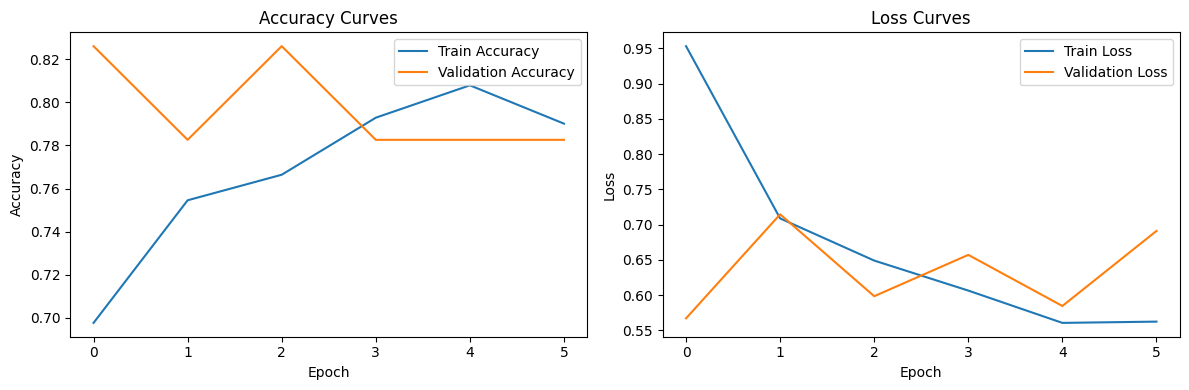

In [76]:
# Visualization
# ========================

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

plot_training_history(history)

In [81]:
from sklearn.metrics import classification_report
import numpy as np

# Generate predictions on the test set
val_generator.reset()
predictions = model.predict(val_generator, verbose=1)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)  # Ensure it's integer labels

# Get true class labels
true_classes = val_generator.classes  # Ensure it's integer labels
class_labels = list(val_generator.class_indices.keys())

# Print the classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


1/1 [==============================] - 0s 339ms/step
                      precision    recall  f1-score   support

           Unlabeled       0.00      0.00      0.00         1
     acne-comedonica       1.00      0.50      0.67         2
     acne-conglobata       0.00      0.00      0.00         1
acne-papulopustulosa       0.00      0.00      0.00         1
               other       0.85      0.94      0.89        18

            accuracy                           0.78        23
           macro avg       0.37      0.29      0.31        23
        weighted avg       0.75      0.78      0.76        23



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 90ms/step


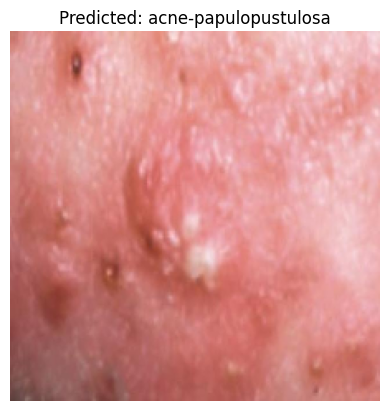

In [90]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_and_preprocess_image(img_path, target_size):
    # Load image
    img = image.load_img(img_path, target_size=target_size)

    # Convert image to array
    img_array = image.img_to_array(img)

    # Rescale the image
    img_array = img_array / 255.0

    # Expand dimensions to match the input shape
    img_array = np.expand_dims(img_array, axis=0)

    return img, img_array

img_path = 'data/test/acne-papulopustulosa/p66_JPG.rf.5cf212e488540efe62d7b81d7e8ce358.jpg'
target_size = (224, 224)  # Make sure this matches your model's input size

# Load and preprocess the image
img, img_array = load_and_preprocess_image(img_path, target_size)

# Make a prediction
prediction = model.predict(img_array)

# Get class labels
class_labels = list(val_generator.class_indices.keys())

# Get the predicted class index
predicted_class_index = np.argmax(prediction)  # Assuming softmax output

# Get the class label
predicted_label = class_labels[predicted_class_index]

# Display the image with the predicted label
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title(f'Predicted: {predicted_label}')
plt.show()

